# Tester

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.utils.data as data
import torchvision
from torch.utils.data import random_split
from tqdm import tqdm, tqdm_notebook
import torch.nn.functional as F
import math
from functools import partial
import matplotlib.pyplot as plt

import facebook_vit
from mae_util import interpolate_pos_embed
from timm.models.layers import trunc_normal_
from facebook_mae import MaskedAutoencoderViT

gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    gpu = 'cuda:' + str(gpu_ids[2])  # GPU Number
else:
    gpu = "cuda" if torch.cuda.is_available() else "cpu"

[0, 1, 2, 3]
['NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090']


In [2]:
device = gpu
BATCH_SIZE = 2048  # 1024
NUM_EPOCHS = 15  # 100
WARMUP_EPOCHS = 5  # 5
NUM_WORKERS = 2
LEARNING_RATE = 6.25e-06  # 1e-03
model_path = './save/mae_vit_base_i2012_ep15_lr6.25e-07.pt'

In [3]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_set = torchvision.datasets.ImageFolder('../datasets/ImageNet/train', transform=transform_train)
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])
train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_set = torchvision.datasets.ImageFolder('../datasets/ImageNet/val', transform=transform_test)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [4]:
class TesterFacebook(object):
    def __init__(self):
        self.model = None
        self.epochs = [0]
        self.losses = [0]
        self.accuracies = [0]

    def process(self):
        self.build_model()
        self.eval_model()

    def build_model(self):
        self.model = facebook_vit.__dict__['vit_base_patch16'](
            num_classes=1000,
            drop_path_rate=0.1,
        )
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['model'])
        self.model.to(device)
        self.epochs = checkpoint['epochs']
        self.losses = checkpoint['losses']
        self.accuracies = checkpoint['accuracies']
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        print(f'Epochs: {self.epochs[-1]}')

    def eval_model(self):
        self.model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in tqdm_notebook(enumerate(test_loader, 0), total=len(test_loader)):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc_test = 100 * correct / total
        print(f'Accuracy of {len(test_set)} test images: {acc_test:.2f} %')

        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in tqdm_notebook(enumerate(val_loader, 0), total=len(val_loader)):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc_val = 100 * correct / total
        print(f'Accuracy of {len(val_set)} val images: {acc_val:.2f} %')

        print(f'Accuracy of test: {acc_test:.2f} %, Accuracy of val: {acc_val:.2f} %')
        
    def lr_checker(self):
        self.build_model()
        model = self.model
        criterion = nn.CrossEntropyLoss()
        optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
        scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
        
        for epoch in range(NUM_EPOCHS):
            if epoch < WARMUP_EPOCHS:
                lr_warmup = ((epoch + 1) / WARMUP_EPOCHS) * LEARNING_RATE
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_warmup
                if epoch + 1 == WARMUP_EPOCHS:
                    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
            lr_now = optimizer.param_groups[0]['lr']
            print(f'epoch {epoch+1} learning rate(={round(lr_now/LEARNING_RATE*100)}%) : {lr_now} ')
            scheduler.step()

In [5]:
def visualTwinx(losses, accuracies):
    fig, ax1 = plt.subplots()
    lim_loss = (0.5, 7)
    lim_acc = (0, 90)

    ax1.plot(losses, 'b', label='Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_ylim(lim_loss)
    ax1.set_title('Training Losses and Accuracies')

    ax2 = ax1.twinx()
    ax2.plot(accuracies, 'r', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params('y', colors='r')
    ax2.set_ylim(lim_acc)

    plt.xticks(range(0, len(losses), 20), range(0, len(losses)//20))

    plt.show()

In [6]:
if __name__ == '__main__':
    t = TesterFacebook()
    t.lr_checker()

Parameter: 86567656
Epochs: 15
epoch 1 learning rate(=20%) : 1.25e-06 
epoch 2 learning rate(=40%) : 2.5e-06 
epoch 3 learning rate(=60%) : 3.75e-06 
epoch 4 learning rate(=80%) : 5e-06 
epoch 5 learning rate(=100%) : 6.25e-06 
epoch 6 learning rate(=99%) : 6.181711252293143e-06 
epoch 7 learning rate(=96%) : 5.979829555133128e-06 
epoch 8 learning rate(=90%) : 5.653178107421711e-06 
epoch 9 learning rate(=83%) : 5.216033144871432e-06 
epoch 10 learning rate(=75%) : 4.6875000000000004e-06 
epoch 11 learning rate(=65%) : 4.090678107421711e-06 
epoch 12 learning rate(=55%) : 3.451651447711418e-06 
epoch 13 learning rate(=45%) : 2.798348552288584e-06 
epoch 14 learning rate(=35%) : 2.15932189257829e-06 
epoch 15 learning rate(=25%) : 1.5625000000000011e-06 


/home/idea/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Parameter: 86567656
Epochs: 15


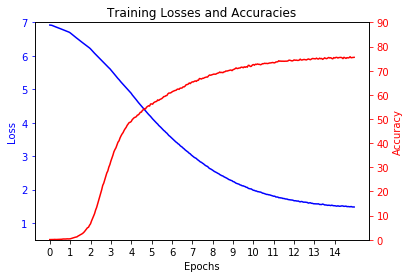

In [7]:
if __name__ == '__main__':
    t = TesterFacebook()
    t.build_model()
    visualTwinx(t.losses, t.accuracies)

In [8]:
if __name__ == '__main__':
    t = TesterFacebook()
    [t.process() for i in range(1)]

Parameter: 86567656
Epochs: 15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25 [00:00<?, ?it/s]

Accuracy of 50000 test images: 73.23 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/126 [00:00<?, ?it/s]

Accuracy of 256234 val images: 80.05 %
Accuracy of test: 73.23 %, Accuracy of val: 80.05 %
